># 【問題1】クロスバリデーション  
事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）  
しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。  
事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

In [257]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
import warnings
import lightgbm as lgb
import itertools
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
warnings.simplefilter("ignore")

In [212]:
#irisデータセット
iris = load_iris()
iris_x = pd.DataFrame(iris.data[:100],columns = ["sepal_width","sepal_length","petal_width","petal_length"])
iris_y = pd.DataFrame(iris.target[:100],columns = ["species"])
iris_data = pd.concat([iris_x,iris_y],axis = 1)

#信用情報データセット
application_train = pd.read_csv("../week3/application_train.csv")
application_test = pd.read_csv("../week4/application_test.csv")
feature_list = ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]
X1 = application_train[feature_list]
y1 = application_train["TARGET"]
X2 = application_test[feature_list]
#訓練用データもテスト用データも３つとも平均値はおよそ0.5であるため今回は0.5で欠損値を埋める
X1 = X1.fillna(0.5)
X2 = X2.fillna(0.5)

In [213]:
#irisデータセット
K = 10
value_percent = np.zeros(4)
kf_iris = KFold(n_splits=K,random_state=1)
for iris_train,iris_test in kf_iris.split(iris_x):
    iris_x_train,iris_x_test = iris_x.iloc[iris_train],iris_x.iloc[iris_test]
    iris_y_train,iris_y_test = iris_y.iloc[iris_train],iris_y.iloc[iris_test]
    scaler_iris = StandardScaler()
    scaler_iris.fit(iris_x_train)
    iris_x_train_std = scaler_iris.transform(iris_x_train)
    iris_x_test_std = scaler_iris.transform(iris_x_test)
    #ランダムフォレスト
    rf = RandomForestClassifier()
    rf.fit(iris_x_train_std,iris_y_train)
    y_pred = rf.predict(iris_x_test_std)
    value_percent += accuracy_score(iris_y_test,y_pred),precision_score(iris_y_test,y_pred),recall_score(iris_y_test,y_pred),f1_score(iris_y_test,y_pred)
print("正解率:{}\n適合率:{}\n再現率:{}\nF値:{}\n".format(*value_percent/K))
    

正解率:1.0
適合率:0.5
再現率:0.5
F値:0.5



In [214]:
#信用情報データセット
K = 4
roc_auc_score_value = 0
accuracy_score_value = 0
kf_credit = KFold(n_splits=K,random_state=0)
for train_index,test_index in kf_credit.split(X1):
    x_train,x_val = X1.iloc[train_index],X1.iloc[test_index]
    y_train,y_val = y1.iloc[train_index],y1.iloc[test_index]
    #x_trainを用いてx_train,x_val,df_test_xを標準化
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_std = scaler.transform(x_train)
    x_val_std = scaler.transform(x_val)
    #ロジスティック回帰
    lr = LogisticRegression()
    lr.fit(x_train_std,y_train)
    #２値分類の予測(0か１が入る)
    y_pred = lr.predict(x_val_std)
    #0になる確率,1になる確率を返す２列の行列（小数が入る）
    y_pred_proba = lr.predict_proba(x_val_std)
    #ROC_AUCスコア
    roc_auc_score_value += roc_auc_score(y_val,y_pred_proba[:,1])
    #正解率
    accuracy_score_value += accuracy_score(y_val,y_pred)
print("{}回の平均".format(K))
print("roc_auc_score:{}".format(roc_auc_score_value/K))
print("accuracy_score(正解率):{}".format(accuracy_score_value/K))

4回の平均
roc_auc_score:0.7194507548282189
accuracy_score(正解率):0.9191573671116733


># 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。  
scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。

In [215]:
x_train,x_val,y_train,y_val = train_test_split(X1,y1,random_state=0)
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train_std = scaler_x.transform(x_train)
x_val_std = scaler_x.transform(x_val)

In [217]:
param_grid = {"penalty":["l1","l2"]},\
              #"C":[0.001,0.01,0.1,1],\
             #"tol":[0.001,0.01,0.1,1],\
             #"multi_class":["auto","ovr","multinomial"],\
             #"solver":["newton-cg","lbfgs", "liblinear"]}
"""
複数のscoringで評価する場合、データ全体で最良のパラメータを持つestimatorをrefitし、
そのmetricでbest_*attributesを使用できるようにするには、パラメータrefitをscorer key
またはcallableに設定する必要がある。これがない場合、refitは明示的にFalseに設定する必要がある。
"""
grid_search = GridSearchCV(LogisticRegression(),param_grid,scoring="roc_auc",cv=K)
x_train,x_val,y_train,y_val = train_test_split(X1,y1,random_state=0)
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train_std = scaler_x.transform(x_train)
x_val_std = scaler_x.transform(x_val)
"""
訓練データを用いてモデル構築。訓練データは内部で
訓練データ（小）と検証データに分かれて交差検証されている。

"""
grid_search.fit(x_train_std,y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(),
             param_grid=({'penalty': ['l1', 'l2']},), scoring='roc_auc')

In [218]:
print("best roc_auc_score:{}".format(grid_search.score(x_val_std,y_val)))
print("best parameters:{}".format(grid_search.best_params_))
display(pd.DataFrame(grid_search.cv_results_).head())
grid_search_params = grid_search.best_params_

best roc_auc_score:0.7185187102649248
best parameters:{'penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004810,0.000301,0.000000,0.000000,l1,{'penalty': 'l1'},NaN,NaN,NaN,NaN,NaN,NaN,2
1,0.080628,0.002256,0.016714,0.002255,l2,{'penalty': 'l2'},0.720556,0.718498,0.717966,0.722103,0.719781,0.001654,1


># 【問題3】Kaggle Notebooksからの調査
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。

>### Notebooksを調べてわかったこと
・Grid Searchはモデル訓練回数が増えるため計算コストが高く、データが大きい時は効率的ではない。  
・自動パラメータチューニングにはGrid Search以外にもRandom Search,Bayesian Optimizationといった手法がある。  
・Notebooks上ではLightGBMを用いてモデル訓練を行なっていることが多い。

>Random Search:  
候補の値をランダムに組み合わせたモデル訓練を行いパラメータを検証する手法。ランダムに検証するため正しい値が出るとは限らないが、回数を決められるためそれほど時間をかけずに計算できる。  

>Bayesian Optimization:  
不確かさを利用して次に探索を行うべき値を探していく手法。「Exploration（探索）」と「Exploitation（活用）」の2つの戦略を使って最適化を順次的に行う。

>今回特に参考にしたNotebooks:  
https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search [1]  
https://www.kaggle.com/willkoehrsen/automated-model-tuning [2]  
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction [3]  
https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761 [4]

># 【問題4】高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。  
その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。



今回はLightGBMでベースラインモデルを作成し、ランダムサーチを用いて適切なハイパーパラメータを求める

In [240]:
#データ数を16000に絞る
features = application_train
# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')
# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (10000, 104)
Test shape:  (6000, 104)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
99825,2,99000.0,562491.0,27189.0,454500.0,0.007330,-10901,-603,-574.0,-3572,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
208378,0,157500.0,677664.0,34731.0,585000.0,0.024610,-12091,-1358,-2918.0,-3715,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0
1309,2,112500.0,864000.0,25393.5,864000.0,0.028663,-11922,-1868,-1465.0,-4580,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
172223,1,63000.0,180000.0,9000.0,180000.0,0.020246,-14570,-7753,-5007.0,-4719,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
258157,0,202500.0,1193580.0,42417.0,855000.0,0.020713,-20925,-1049,-3149.0,-4437,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [241]:
N_FOLDS = 5
MAX_EVALS = 5

In [242]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [250]:
#後にランダムサーチ前と後で比較するための辞書
value = {}
# Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))
value["LightGBM(cross validation)"] = best

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknow

In [251]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))
value["LightGBM(default)"] = baseline_auc

The baseline model scores 0.70650 ROC AUC on the test set.


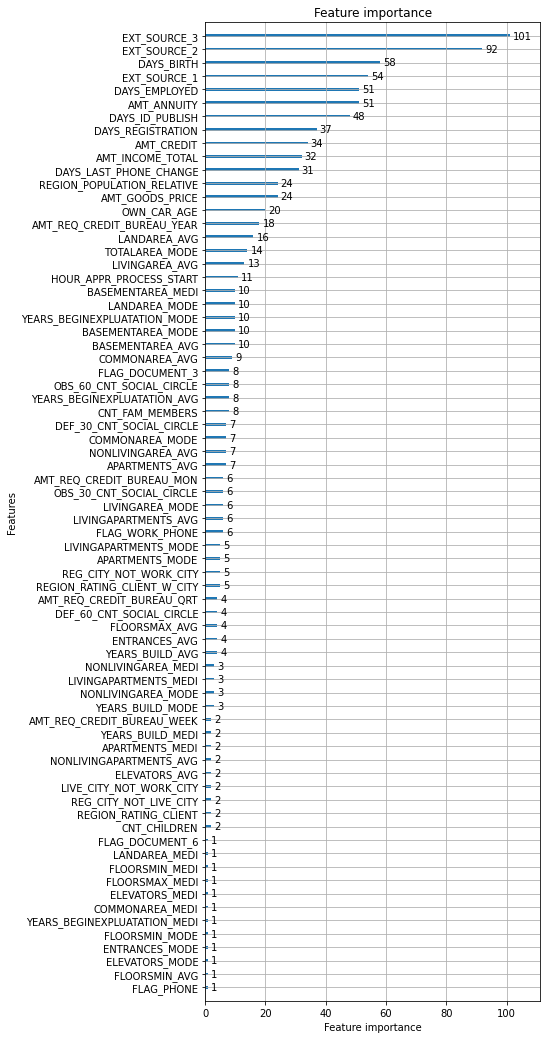

In [226]:
#特徴量の重要度を可視化する
lgb.plot_importance(model,figsize=(6,18))
plt.show()

In [227]:
#重要度が上位20件の特徴量を用いる
features_list = ["EXT_SOURCE_3","EXT_SOURCE_2","DAYS_BIRTH","EXT_SOURCE_1","DAYS_EMPLOYED",\
                 "AMT_ANNUITY","DAYS_ID_PUBLISH","DAYS_REGISTRATION","AMT_CREDIT","AMT_INCOME_TOTAL",\
                 "DAYS_LAST_PHONE_CHANGE","REGION_POPULATION_RELATIVE","AMT_GOODS_PRICE","OWN_CAR_AGE",\
                "LANDAREA_MODE","LANDAREA_AVG","TOTALAREA_MODE","LIVINGAREA_AVG",\
                 "HOUR_APPR_PROCESS_START","BASEMENTAREA_MEDI"]
features = features[features_list]

In [228]:
# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (10000, 20)
Test shape:  (6000, 20)


,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,DAYS_EMPLOYED,AMT_ANNUITY,DAYS_ID_PUBLISH,DAYS_REGISTRATION,AMT_CREDIT,AMT_INCOME_TOTAL,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,OWN_CAR_AGE,LANDAREA_MODE,LANDAREA_AVG,TOTALAREA_MODE,LIVINGAREA_AVG,HOUR_APPR_PROCESS_START,BASEMENTAREA_MEDI
99825,0.652897,0.364905,-10901,NaN,-603,27189.0,-3572,-574.0,562491.0,99000.0,0.0,0.007330,454500.0,22.0,NaN,NaN,NaN,NaN,11,NaN
208378,0.661024,0.598669,-12091,0.298256,-1358,34731.0,-3715,-2918.0,677664.0,157500.0,-560.0,0.024610,585000.0,NaN,NaN,NaN,NaN,NaN,15,NaN
1309,0.577969,0.240739,-11922,NaN,-1868,25393.5,-4580,-1465.0,864000.0,112500.0,-1206.0,0.028663,864000.0,NaN,NaN,NaN,NaN,NaN,10,NaN
172223,NaN,0.428255,-14570,0.146889,-7753,9000.0,-4719,-5007.0,180000.0,63000.0,-709.0,0.020246,180000.0,NaN,NaN,NaN,NaN,NaN,11,NaN
258157,0.569149,0.053220,-20925,NaN,-1049,42417.0,-4437,-3149.0,1193580.0,202500.0,-1184.0,0.020713,855000.0,64.0,0.0565,0.0552,0.0851,0.0583,12,0.1072


In [229]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [230]:
# Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))
value["LightGBM(selected features)"] = best

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4329
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 20
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

In [231]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [232]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(random_state=50)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_val_std,y_val)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [233]:
#LightGBMの最適なパラメータをランダムサーチを用いて求める
gs.fit(x_train_std, y_train, **fit_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Early stopping, best iteration is:
[39]	valid's auc: 0.722605	valid's binary_logloss: 0.252707
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid's auc: 0.722452	valid's binary_logloss: 0.252684
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid's auc: 0.722308	valid's binary_logloss: 0.252735
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid's auc: 0.722314	valid's binary_logloss: 0.252688
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid's auc: 0.722162	valid's binary_logloss: 0.25274
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid's auc: 0.722263	valid's binary_logloss: 0.252728
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5	valid's b

Early stopping, best iteration is:
[64]	valid's auc: 0.723136	valid's binary_logloss: 0.252524
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid's auc: 0.722536	valid's binary_logloss: 0.252643
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.681935	valid's binary_logloss: 0.261152
Did not meet early stopping. Best iteration is:
[78]	valid's auc: 0.681944	valid's binary_logloss: 0.261158
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid's auc: 0.682064	valid's binary_logloss: 0.26138
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[69]	valid's auc: 0.682266	valid's binary_logloss: 0.26116
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid's auc: 0.721684	valid's binary_logloss: 0.252953
Training until validation scores don't improve for 30

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5	valid's binary_logloss: 0.392163
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.681705	valid's binary_logloss: 0.26116
Did not meet early stopping. Best iteration is:
[76]	valid's auc: 0.681762	valid's binary_logloss: 0.261164
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid's auc: 0.682069	valid's binary_logloss: 0.261345
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid's auc: 0.682085	valid's binary_logloss: 0.261581
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid's auc: 0.722295	valid's binary_logloss: 0.252726
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid's auc: 0.722246	valid's binary_logloss: 0.2527

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5	valid's binary_logloss: 0.392174
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5	valid's binary_logloss: 0.392163
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid's auc: 0.681164	valid's binary_logloss: 0.261419
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid's auc: 0.681143	valid's binary_logloss: 0.261562
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.681373	valid's binary_logloss: 0.261291
Did not meet early stopping. Best iteration is:
[97]	valid's auc: 0.681502	valid's binary_logloss: 0.261288
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid's auc: 0.681366	valid's binary_logloss: 0.261103
Tr

Early stopping, best iteration is:
[42]	valid's auc: 0.722162	valid's binary_logloss: 0.25276
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.68211	valid's binary_logloss: 0.261059
Did not meet early stopping. Best iteration is:
[95]	valid's auc: 0.682136	valid's binary_logloss: 0.26106
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.682334	valid's binary_logloss: 0.261007
Did not meet early stopping. Best iteration is:
[88]	valid's auc: 0.682367	valid's binary_logloss: 0.261011
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid's auc: 0.682373	valid's binary_logloss: 0.261052
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.681911	valid's binary_logloss: 0.261079
Did not meet early stopping. Best iteration is:
[77]	valid's auc: 0.682165	valid's binary_logloss: 0.261063
Training until validation scores don't improve for 30 rounds
E

[100]	valid's auc: 0.721403	valid's binary_logloss: 0.253024
Did not meet early stopping. Best iteration is:
[92]	valid's auc: 0.721422	valid's binary_logloss: 0.253026
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.722105	valid's binary_logloss: 0.252865
Did not meet early stopping. Best iteration is:
[100]	valid's auc: 0.722105	valid's binary_logloss: 0.252865
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid's auc: 0.721988	valid's binary_logloss: 0.252985
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid's auc: 0.722097	valid's binary_logloss: 0.252805
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid's auc: 0.722288	valid's binary_logloss: 0.25275
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid's auc: 0.722353	valid's bi

Early stopping, best iteration is:
[64]	valid's auc: 0.722749	valid's binary_logloss: 0.252638
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid's auc: 0.722371	valid's binary_logloss: 0.252756
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid's auc: 0.722572	valid's binary_logloss: 0.252727
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid's auc: 0.722182	valid's binary_logloss: 0.252798
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid's auc: 0.681976	valid's binary_logloss: 0.26108
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid's auc: 0.682385	valid's binary_logloss: 0.260982
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid's auc: 0.682421	val

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.2min finished


[100]	valid's auc: 0.723234	valid's binary_logloss: 0.2525
Did not meet early stopping. Best iteration is:
[96]	valid's auc: 0.723246	valid's binary_logloss: 0.252497


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=50), n_iter=100,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc78f836978>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc73db75518>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc78fcee6d8>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50,
   

In [253]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
value["LightGBM(Random Search)"] = gs.best_score_

Best score reached: 0.7237985945737812 with params: {'colsample_bytree': 0.845713494190162, 'min_child_samples': 387, 'min_child_weight': 1, 'num_leaves': 11, 'reg_alpha': 1, 'reg_lambda': 20, 'subsample': 0.4851977966426663} 


In [256]:
#時間短縮用にopt_parametersを書き出す
#opt_parameters = {'colsample_bytree': 0.845713494190162, 'min_child_samples': 387, 'min_child_weight': 1, 'num_leaves': 11, 'reg_alpha': 1, 'reg_lambda': 20, 'subsample': 0.4851977966426663}
opt_parameters = gs.best_params_
pd.DataFrame(value,index=["ROC_AUC"]).sort_values(by="ROC_AUC",axis=1)

,LightGBM(default),LightGBM(cross validation),LightGBM(Random Search)
ROC_AUC,0.706502,0.720461,0.723799


In [236]:
X = application_train[features_list]
y = application_train.TARGET
X_test= application_test[features_list]

In [237]:
#train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

test_model = lgb.LGBMClassifier(random_state=50,**opt_parameters)

test_model.fit(X,y)
preds = test_model.predict_proba(X_test)[:,1]
submission = pd.DataFrame({"SK_ID_CURR":application_test.SK_ID_CURR,"TARGET":preds})
submission.to_csv('submission_simple_features_random.csv', index = False)

># 【問題5】最終的なモデルの選定  
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

今回はより良い精度が欲しかったため、ロジスティック回帰ではなくLightGBMでベースラインモデルを作成した。計算時間を短縮したかったため、データを16000件にまで絞った。また、パラメータチューニングでも計算時間を短縮したかったため、ランダムサーチを用いて適切なハイパーパラメータを求めた  
score:0.73534  
順位は5600位くらいの位置